In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

# Recommendation system  model-1

First, install and import TFRS:

In [13]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [14]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

### Read the data

In [15]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

Build vocabularies to convert user ids and movie titles into integer indices for embedding layers:

In [16]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### Define a model

## Define user and movie models with additional layers and dropout

In [17]:

def build_user_model(user_ids_vocabulary):
    return tf.keras.Sequential([
        user_ids_vocabulary,
        tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
    ])

def build_movie_model(movie_titles_vocabulary):
    return tf.keras.Sequential([
        movie_titles_vocabulary,
        tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
    ])

In [18]:
# Define a callback to track the training loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()


##set up the retrieval

In [19]:
model.fit(ratings.batch(4096), epochs=3)

# Set up retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)



Epoch 1/3
25/25 [==============================] - 38s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 3.7000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0058 - factorized_top_k/top_50_categorical_accuracy: 0.0298 - factorized_top_k/top_100_categorical_accuracy: 0.0604
Epoch 2/3
25/25 [==============================] - 37s 1s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.4000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0058 - factorized_top_k/top_50_categorical_accuracy: 0.0301 - factorized_top_k/top_100_categorical_accuracy: 0.0606
Epoch 3/3
25/25 [==============================] - 38s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0058 - factorized_top_k/top_50_categorical_accur

In [38]:
# Train the model
model.fit(ratings.batch(4096), epochs=3, callbacks=[history])

Epoch 1/3
25/25 [==============================] - 39s 2s/step - loss: 0.6932 - factorized_top_k/top_1_categorical_accuracy: 3.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0291 - factorized_top_k/top_100_categorical_accuracy: 0.0591
Epoch 2/3
25/25 [==============================] - 40s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 3.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0292 - factorized_top_k/top_100_categorical_accuracy: 0.0594
Epoch 3/3
25/25 [==============================] - 37s 1s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 3.8000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accur

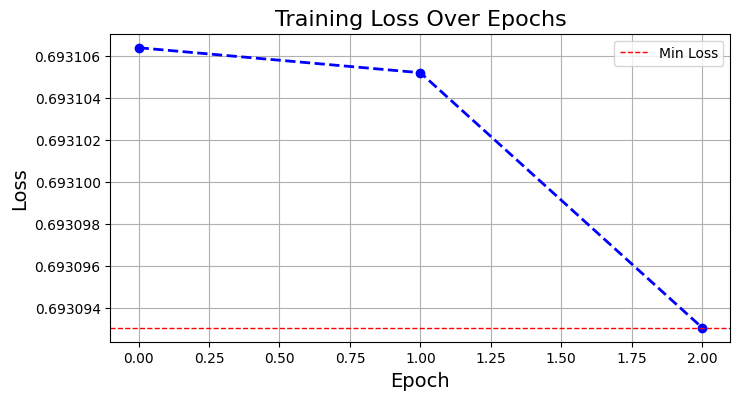

In [21]:
# Plot the training loss with colors
plt.figure(figsize=(8, 4))
plt.plot(history.losses, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.axhline(y=min(history.losses), color='red', linestyle='--', linewidth=1, label='Min Loss')
plt.legend()
plt.show()

#Get Recommendation

In [39]:
# Get recommendations for a specific user
_, titles = index(np.array(["42"]))

# Print recommendations as bulleted points
print("Top 10 recommendations for user 42:")
for i, title in enumerate(titles[0, :10].numpy(), start=1):
    print(f"{i}. {title.decode('utf-8')}")

Top 10 recommendations for user 42:
1. For Richer or Poorer (1997)
2. G.I. Jane (1997)
3. Some Folks Call It a Sling Blade (1993)
4. Old Man and the Sea, The (1958)
5. Target (1995)
6. Trees Lounge (1996)
7. Diva (1981)
8. Mother Night (1996)
9. Fall (1997)
10. Deconstructing Harry (1997)


#Recommendation system model-2

##import libraries

In [23]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt


##loading and preparing data

In [24]:
# Load ratings and movies data
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select basic features
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

# Prepare vocabulary for user ids and movie titles
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)


##Define the model

In [25]:
class MovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.task = tfrs.tasks.Retrieval()

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        user_embeddings = self.dropout(user_embeddings, training=training)
        movie_embeddings = self.dropout(movie_embeddings, training=training)

        return self.task(user_embeddings, movie_embeddings)


##Define user and movie model

In [26]:
class MovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.interaction_layer = tf.keras.layers.Dot(axes=1)
        self.task = tfrs.tasks.Retrieval()

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        interaction = self.interaction_layer([user_embeddings, movie_embeddings])

        return self.task(interaction)


In [27]:
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])


In [28]:
# Train the model
model.fit(ratings.batch(4096), epochs=3)


Epoch 1/3
25/25 [==============================] - 38s 1s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0060 - factorized_top_k/top_50_categorical_accuracy: 0.0308 - factorized_top_k/top_100_categorical_accuracy: 0.0619
Epoch 2/3
25/25 [==============================] - 38s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.9000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0060 - factorized_top_k/top_50_categorical_accuracy: 0.0310 - factorized_top_k/top_100_categorical_accuracy: 0.0622
Epoch 3/3
25/25 [==============================] - 37s 1s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.3000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0029 - factorized_top_k/top_10_categorical_accuracy: 0.0061 - factorized_top_k/top_50_categorical_accur

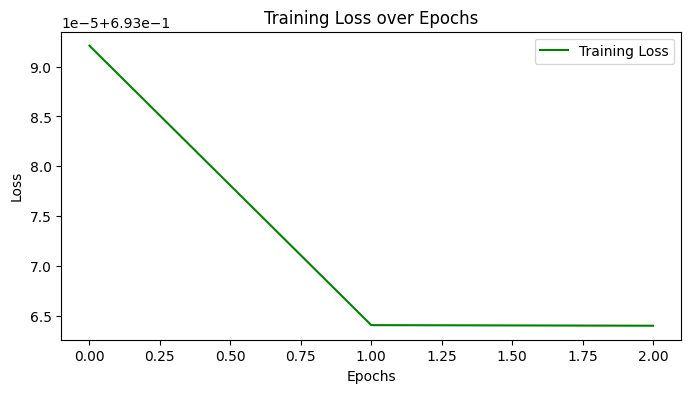

In [29]:
history = model.history.history

plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss', color='green')  # Change color here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

In [31]:
# Use brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations for a specific user (user id = "42")
_, titles = index(np.array(["42"]))
print("Top 10 recommendations for user 42:")
for i, title in enumerate(titles[0, :10], start=1):
    print(f"{i}. {title.numpy().decode('utf-8')}")


Top 10 recommendations for user 42:
1. For Richer or Poorer (1997)
2. G.I. Jane (1997)
3. Some Folks Call It a Sling Blade (1993)
4. Old Man and the Sea, The (1958)
5. Target (1995)
6. Trees Lounge (1996)
7. Diva (1981)
8. Mother Night (1996)
9. Fall (1997)
10. Deconstructing Harry (1997)


#Recomendation system model-3

##Install libraries

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets


##Import libraries and load data

In [32]:
from typing import Dict
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

# Load MovieLens 100k dataset
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

##preprocess data

In [33]:
# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

# Vocabulary layers for user_ids and movie_titles
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

##Define model

In [34]:
# Part 4: Define the BPR Model
class BPRModel(tf.keras.Model):
    def __init__(self, user_model: tf.keras.Model, movie_model: tf.keras.Model, task: tfrs.tasks.Retrieval):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def call(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # Generate negative samples
        negative_movie_embeddings = self.movie_model(tf.random.shuffle(features["movie_title"]))

        # Calculate the BPR loss
        positive_scores = tf.reduce_sum(user_embeddings * positive_movie_embeddings, axis=1)
        negative_scores = tf.reduce_sum(user_embeddings * negative_movie_embeddings, axis=1)
        bpr_loss = -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(positive_scores - negative_scores)))

        self.add_loss(bpr_loss)  # Add BPR loss to model's losses

        return self.task(user_embeddings, positive_movie_embeddings)

# Define user and movie embedding dimensions
embedding_dim = 64

# User model with embedding layer
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), embedding_dim)
])

# Movie model with embedding layer
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), embedding_dim)
])

# Define retrieval task for evaluation
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        movies.batch(128).map(movie_model)
    )
)

In [35]:
# Create the BPR model instance
model = BPRModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5), run_eagerly=True)


##Verify data


In [36]:
# Check if the ratings dataset is not empty
print("Number of ratings:", len(list(ratings.as_numpy_iterator())))
print("Number of movies:", len(list(movies.as_numpy_iterator())))

# Print some samples
for rating in ratings.take(1):
    print("Sample rating:", rating)


Number of ratings: 100000
Number of movies: 1682
Sample rating: {'movie_title': <tf.Tensor: shape=(), dtype=string, numpy=b"One Flew Over the Cuckoo's Nest (1975)">, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'138'>}


##Train the data

Epoch 1/3
25/25 [==============================] - 42s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 3.8000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0295 - factorized_top_k/top_100_categorical_accuracy: 0.0599
Epoch 2/3
25/25 [==============================] - 38s 1s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 4.2000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0056 - factorized_top_k/top_50_categorical_accuracy: 0.0296 - factorized_top_k/top_100_categorical_accuracy: 0.0603
Epoch 3/3
25/25 [==============================] - 39s 2s/step - loss: 0.6931 - factorized_top_k/top_1_categorical_accuracy: 3.7000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0027 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accur

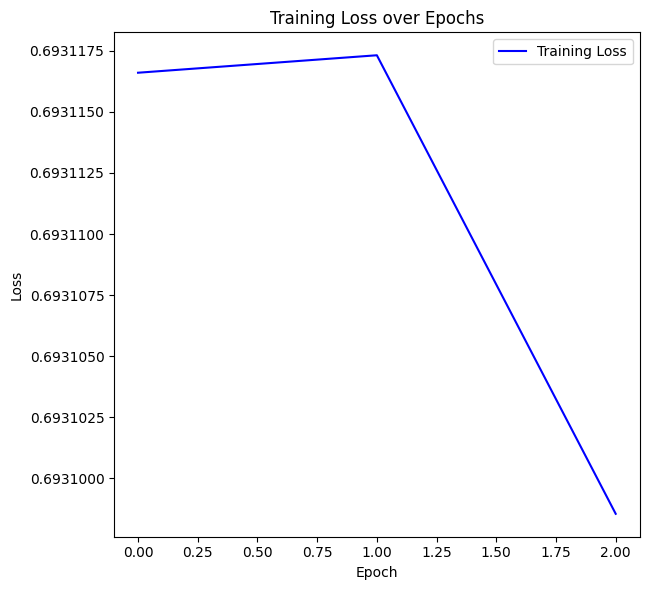

In [40]:
# Train the model for 3 epochs
history = model.fit(ratings.batch(4096), epochs=3)

# Visualize training history with colorful graphs
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss (if available)
if 'val_loss' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title('Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


##Retrieve and Display Recommendations

In [41]:
# Set up retrieval using brute-force search with trained representations
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get recommendations for a specific user
_, titles = index(np.array(["42"]))
print("Top 10 recommendations for user 42:")
for i, title in enumerate(titles[0, :10], 1):
    print(f"{i}. {title.numpy().decode('utf-8')}")

Top 10 recommendations for user 42:
1. Rough Magic (1995)
2. Touch (1997)
3. Misérables, Les (1995)
4. Race the Sun (1996)
5. Sex, Lies, and Videotape (1989)
6. Niagara, Niagara (1997)
7. Desperate Measures (1998)
8. Desperate Measures (1998)
9. Chasing Amy (1997)
10. Chasing Amy (1997)
